In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'


# Load Data and Policy

In [3]:
# Read data files
adata, = celltrip.utility.processing.read_adatas('../data/VirtualCell/expression.h5ad', backed=True)  # 's3://nkalafut-celltrip/VirtualCell/expression.h5ad'
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251001', 800  # No mask
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251006', 800  # Normal
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007', 800  # 16 dim - Not much diff. betw. runs
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog', 800  # 16 dim - sample and log norm
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog-32', 800  # 32 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251008-celllog-64', 800  # 64 dim, 1024 PCA
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# assert (adata.obs['training'] == mask).all()
# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=100, vision_size=1_000).eval().to('cuda')  # TODO Forward batch size reduced
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [ ]:
preprocessing_nopca = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
preprocessing_nopca.pca_dim = None

# Generate Steady State

In [5]:
# # Get random sample
# np.random.seed(42)
# sample_idx = np.sort(np.random.choice(adata.obs.shape[0], 10_000, replace=False))
# m1_raw = celltrip.utility.processing.chunk(adata.X[sample_idx], chunk_size=2_000)
# m1, = preprocessing.transform([m1_raw])

In [6]:
# # Create environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), compute_rewards=False, dim=8).eval(time_scale=1).to('cuda')

# # Simulate
# ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
# steady_state = ret[-1][-1, :, :env.dim]
# # target_state = env.modalities[env.target_modalities[0]].cpu()

# # Impute
# with torch.no_grad():
#     imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()
# imputed_steady_state, = preprocessing.inverse_transform([imputed_steady_state])

# # Compute accuracy
# mse = np.square(m1_raw - imputed_steady_state).mean()
# print(f'MSE: {mse:.3f}')

In [7]:
# # Latent space plot
# red = umap.UMAP(random_state=42)
# df = pd.DataFrame(index=sample_idx)
# df[['X_lat', 'Y_lat']] = red.fit_transform(steady_state)
# df['Target'] = adata[sample_idx].obs['target_gene'].to_numpy()
# df['Select Targets'] = df['Target']
# df.loc[~df['Target'].isin(['TMSB4X', 'EWSR1', 'non-targeting']), 'Select Targets'] = 'Other'
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# sns.scatterplot(df, x='X_lat', y='Y_lat', hue='Select Targets', s=5, legend=True, ax=ax)

# Predict Perturbation Outcomes

In [ ]:
# Get non-targeting
non_targeting_sample_idx = np.argwhere(adata.obs['target_gene']=='non-targeting').flatten()
np.random.seed(42)
non_targeting_sample_idx = np.sort(np.random.choice(non_targeting_sample_idx, 2_000, replace=False))  # Subsample for performance TODO
non_targeting_raw = celltrip.utility.processing.chunk(adata.X[non_targeting_sample_idx], chunk_size=2_000)
non_targeting_trans, = preprocessing.transform([non_targeting_raw])

# Create environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(non_targeting_trans), compute_rewards=False, dim=env.dim).eval(time_scale=1).to('cuda')

# Simulate (Runs at around .61x realtime on 38k cells!)
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
non_targeting_steady_state = ret[-1][-1]

# Impute
with torch.no_grad():
    imputed_non_targeting_steady_state = policy.pinning[0](non_targeting_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
imputed_non_targeting_steady_state, = preprocessing.inverse_transform([imputed_non_targeting_steady_state])


0it [00:00, ?it/s]


1it [00:01,  1.79s/it]


3it [00:01,  1.95it/s]


5it [00:02,  3.52it/s]


7it [00:02,  5.22it/s]


9it [00:02,  6.67it/s]


11it [00:02,  8.31it/s]


13it [00:02,  9.79it/s]


15it [00:02, 11.06it/s]


17it [00:02, 12.11it/s]


19it [00:03, 12.93it/s]


21it [00:03, 13.56it/s]


23it [00:03, 14.04it/s]


25it [00:03, 14.38it/s]


27it [00:03, 14.63it/s]


29it [00:03, 14.80it/s]


31it [00:03, 14.91it/s]


33it [00:03, 15.00it/s]


35it [00:04, 15.06it/s]


37it [00:04, 15.12it/s]


39it [00:04, 15.16it/s]


41it [00:04, 15.09it/s]


43it [00:04, 15.10it/s]


45it [00:04, 15.08it/s]


47it [00:04, 15.09it/s]


49it [00:04, 15.09it/s]


51it [00:05, 15.08it/s]


53it [00:05, 15.09it/s]


55it [00:05, 15.09it/s]


57it [00:05, 15.09it/s]


59it [00:05, 15.09it/s]


61it [00:05, 15.08it/s]


63it [00:05, 15.08it/s]


65it [00:06, 15.09it/s]


67it [00:06, 15.11it/s]


69it [00:06, 15.11it/s]


71it [00:06, 15.10it/s]


73it [00:06, 15.09it/s]


75it [00:06, 15.09it/s]


77it [00:06, 15.09it/s]


79it [00:06, 15.09it/s]


81it [00:07, 15.10it/s]


83it [00:07, 15.10it/s]


85it [00:07, 15.10it/s]


87it [00:07, 15.11it/s]


89it [00:07, 15.10it/s]


91it [00:07, 15.10it/s]


93it [00:07, 15.07it/s]


95it [00:08, 15.07it/s]


97it [00:08, 15.08it/s]


99it [00:08, 15.09it/s]


101it [00:08, 15.06it/s]


103it [00:08, 15.01it/s]


105it [00:08, 15.04it/s]


107it [00:08, 15.05it/s]


109it [00:08, 15.05it/s]


111it [00:09, 15.06it/s]


113it [00:09, 15.06it/s]


115it [00:09, 15.05it/s]


117it [00:09, 15.04it/s]


119it [00:09, 15.05it/s]


121it [00:09, 15.05it/s]


123it [00:09, 15.06it/s]


125it [00:10, 15.06it/s]


127it [00:10, 15.07it/s]


129it [00:10, 15.07it/s]


131it [00:10, 15.08it/s]


133it [00:10, 15.08it/s]


135it [00:10, 15.08it/s]


137it [00:10, 15.06it/s]


139it [00:10, 15.08it/s]


141it [00:11, 15.08it/s]


143it [00:11, 15.08it/s]


145it [00:11, 15.07it/s]


147it [00:11, 14.97it/s]


149it [00:11, 15.01it/s]


151it [00:11, 15.03it/s]


153it [00:11, 15.05it/s]


155it [00:12, 15.06it/s]


157it [00:12, 15.07it/s]


159it [00:12, 15.07it/s]


161it [00:12, 15.08it/s]


163it [00:12, 15.09it/s]


165it [00:12, 15.09it/s]


167it [00:12, 15.07it/s]


169it [00:12, 15.08it/s]


171it [00:13, 14.97it/s]


173it [00:13, 15.01it/s]


175it [00:13, 15.04it/s]


177it [00:13, 15.06it/s]


179it [00:13, 15.07it/s]


181it [00:13, 15.07it/s]


183it [00:13, 15.07it/s]


185it [00:14, 15.08it/s]


187it [00:14, 15.08it/s]


189it [00:14, 15.09it/s]


191it [00:14, 15.08it/s]


193it [00:14, 15.09it/s]


195it [00:14, 15.10it/s]


197it [00:14, 15.08it/s]


199it [00:14, 15.07it/s]


201it [00:15, 15.06it/s]


203it [00:15, 15.07it/s]


205it [00:15, 15.07it/s]


207it [00:15, 15.08it/s]


209it [00:15, 15.08it/s]


211it [00:15, 15.08it/s]


213it [00:15, 15.07it/s]


215it [00:15, 15.08it/s]


217it [00:16, 15.07it/s]


219it [00:16, 15.08it/s]


221it [00:16, 15.03it/s]


223it [00:16, 15.03it/s]


225it [00:16, 15.05it/s]


227it [00:16, 15.05it/s]


229it [00:16, 15.05it/s]


231it [00:17, 15.06it/s]


233it [00:17, 15.08it/s]


235it [00:17, 15.08it/s]


237it [00:17, 15.08it/s]


239it [00:17, 15.09it/s]


241it [00:17, 15.13it/s]


243it [00:17, 15.11it/s]


245it [00:17, 15.12it/s]


247it [00:18, 15.13it/s]


249it [00:18, 15.14it/s]


251it [00:18, 15.15it/s]


253it [00:18, 15.12it/s]


255it [00:18, 15.06it/s]


257it [00:18, 15.08it/s]


259it [00:18, 15.08it/s]


261it [00:19, 15.10it/s]


263it [00:19, 15.10it/s]


265it [00:19, 15.11it/s]


267it [00:19, 15.12it/s]


269it [00:19, 15.12it/s]


271it [00:19, 15.12it/s]


273it [00:19, 15.09it/s]


275it [00:19, 15.08it/s]


277it [00:20, 15.08it/s]


279it [00:20, 15.08it/s]


281it [00:20, 15.08it/s]


283it [00:20, 15.07it/s]


285it [00:20, 15.07it/s]


287it [00:20, 15.07it/s]


289it [00:20, 15.05it/s]


291it [00:21, 15.06it/s]


293it [00:21, 14.97it/s]


295it [00:21, 15.00it/s]


297it [00:21, 15.02it/s]


299it [00:21, 15.03it/s]


301it [00:21, 15.03it/s]


303it [00:21, 15.06it/s]


305it [00:21, 15.06it/s]


307it [00:22, 15.07it/s]


309it [00:22, 15.08it/s]


311it [00:22, 15.08it/s]


313it [00:22, 15.08it/s]


315it [00:22, 15.09it/s]


317it [00:22, 15.08it/s]


319it [00:22, 15.07it/s]


321it [00:23, 15.07it/s]


323it [00:23, 15.08it/s]


325it [00:23, 15.08it/s]


327it [00:23, 15.08it/s]


329it [00:23, 15.08it/s]


331it [00:23, 15.08it/s]


333it [00:23, 15.08it/s]


335it [00:23, 15.09it/s]


337it [00:24, 15.09it/s]


339it [00:24, 15.09it/s]


341it [00:24, 15.08it/s]


343it [00:24, 15.08it/s]


345it [00:24, 15.09it/s]


347it [00:24, 15.09it/s]


349it [00:24, 15.07it/s]


351it [00:25, 15.08it/s]


353it [00:25, 15.08it/s]


355it [00:25, 15.08it/s]


357it [00:25, 15.08it/s]


359it [00:25, 15.08it/s]


361it [00:25, 15.09it/s]


363it [00:25, 15.07it/s]


365it [00:25, 15.08it/s]


367it [00:26, 15.08it/s]


369it [00:26, 15.08it/s]


371it [00:26, 15.08it/s]


373it [00:26, 15.08it/s]


375it [00:26, 15.08it/s]


377it [00:26, 15.08it/s]


379it [00:26, 15.06it/s]


381it [00:27, 15.07it/s]


383it [00:27, 15.08it/s]


385it [00:27, 15.08it/s]


387it [00:27, 15.08it/s]


389it [00:27, 15.08it/s]


391it [00:27, 15.08it/s]


393it [00:27, 15.07it/s]


395it [00:27, 15.08it/s]


397it [00:28, 15.08it/s]


399it [00:28, 15.09it/s]


401it [00:28, 15.08it/s]


403it [00:28, 15.08it/s]


405it [00:28, 15.08it/s]


407it [00:28, 15.10it/s]


409it [00:28, 15.08it/s]


411it [00:28, 15.06it/s]


413it [00:29, 15.06it/s]


415it [00:29, 15.07it/s]


417it [00:29, 15.07it/s]


419it [00:29, 15.08it/s]


421it [00:29, 15.08it/s]


423it [00:29, 15.09it/s]


425it [00:29, 15.08it/s]


427it [00:30, 15.09it/s]


429it [00:30, 15.09it/s]


431it [00:30, 15.08it/s]


433it [00:30, 15.08it/s]


435it [00:30, 15.03it/s]


437it [00:30, 15.01it/s]


439it [00:30, 15.03it/s]


441it [00:30, 15.03it/s]


443it [00:31, 15.05it/s]


445it [00:31, 15.06it/s]


447it [00:31, 15.06it/s]


449it [00:31, 15.07it/s]


451it [00:31, 15.07it/s]


453it [00:31, 15.07it/s]


455it [00:31, 15.07it/s]


457it [00:32, 15.07it/s]


459it [00:32, 15.08it/s]


461it [00:32, 15.08it/s]


463it [00:32, 14.99it/s]


465it [00:32, 15.02it/s]


467it [00:32, 15.03it/s]


469it [00:32, 15.04it/s]


471it [00:32, 15.04it/s]


473it [00:33, 15.05it/s]


475it [00:33, 15.06it/s]


477it [00:33, 15.07it/s]


479it [00:33, 15.08it/s]


481it [00:33, 15.07it/s]


483it [00:33, 15.07it/s]


485it [00:33, 15.07it/s]


487it [00:34, 15.08it/s]


489it [00:34, 15.07it/s]


491it [00:34, 15.08it/s]


493it [00:34, 15.07it/s]


495it [00:34, 15.07it/s]


497it [00:34, 15.07it/s]


499it [00:34, 15.08it/s]


501it [00:34, 15.05it/s]


503it [00:35, 15.06it/s]


505it [00:35, 15.07it/s]


507it [00:35, 15.07it/s]


509it [00:35, 15.07it/s]


511it [00:35, 15.07it/s]


513it [00:35, 15.08it/s]


515it [00:35, 15.07it/s]


517it [00:36, 15.08it/s]


519it [00:36, 15.07it/s]


521it [00:36, 15.07it/s]


523it [00:36, 15.07it/s]


525it [00:36, 15.07it/s]


527it [00:36, 15.07it/s]


529it [00:36, 14.98it/s]


531it [00:36, 15.00it/s]


533it [00:37, 15.01it/s]


535it [00:37, 15.03it/s]


537it [00:37, 15.04it/s]


539it [00:37, 15.06it/s]


541it [00:37, 15.06it/s]


543it [00:37, 15.07it/s]


545it [00:37, 15.07it/s]


547it [00:38, 15.09it/s]


549it [00:38, 15.10it/s]


551it [00:38, 15.09it/s]


553it [00:38, 15.09it/s]


555it [00:38, 15.09it/s]


557it [00:38, 15.08it/s]


559it [00:38, 15.09it/s]


561it [00:38, 15.08it/s]


563it [00:39, 15.07it/s]


565it [00:39, 15.07it/s]


567it [00:39, 15.08it/s]


569it [00:39, 15.07it/s]


571it [00:39, 15.08it/s]


573it [00:39, 15.07it/s]


575it [00:39, 15.06it/s]


577it [00:40, 15.07it/s]


579it [00:40, 15.07it/s]


581it [00:40, 15.08it/s]


583it [00:40, 15.07it/s]


585it [00:40, 15.07it/s]


587it [00:40, 15.08it/s]


589it [00:40, 15.07it/s]


591it [00:40, 14.99it/s]


593it [00:41, 14.99it/s]


595it [00:41, 15.01it/s]


597it [00:41, 15.03it/s]


599it [00:41, 15.05it/s]


601it [00:41, 15.04it/s]


603it [00:41, 15.05it/s]


605it [00:41, 15.07it/s]


607it [00:42, 15.07it/s]


609it [00:42, 15.07it/s]


611it [00:42, 15.08it/s]


613it [00:42, 15.07it/s]


615it [00:42, 15.07it/s]


617it [00:42, 15.07it/s]


619it [00:42, 15.07it/s]


621it [00:42, 15.07it/s]


623it [00:43, 15.07it/s]


625it [00:43, 15.06it/s]


627it [00:43, 15.06it/s]


629it [00:43, 15.07it/s]


631it [00:43, 15.07it/s]


633it [00:43, 15.07it/s]


635it [00:43, 15.08it/s]


637it [00:44, 15.08it/s]


639it [00:44, 15.08it/s]


641it [00:44, 15.07it/s]


643it [00:44, 15.07it/s]


645it [00:44, 15.06it/s]


647it [00:44, 15.06it/s]


649it [00:44, 15.06it/s]


651it [00:44, 15.06it/s]


653it [00:45, 15.05it/s]


655it [00:45, 15.06it/s]


657it [00:45, 15.05it/s]


659it [00:45, 15.06it/s]


661it [00:45, 15.06it/s]


663it [00:45, 15.06it/s]


665it [00:45, 15.07it/s]


667it [00:45, 15.07it/s]


669it [00:46, 15.08it/s]


671it [00:46, 15.08it/s]


673it [00:46, 15.06it/s]


675it [00:46, 15.06it/s]


677it [00:46, 15.06it/s]


679it [00:46, 15.07it/s]


681it [00:46, 15.07it/s]


683it [00:47, 15.05it/s]


685it [00:47, 15.05it/s]


687it [00:47, 15.06it/s]


689it [00:47, 15.05it/s]


691it [00:47, 15.06it/s]


693it [00:47, 15.06it/s]


695it [00:47, 15.07it/s]


697it [00:47, 15.07it/s]


699it [00:48, 15.07it/s]


701it [00:48, 15.05it/s]


703it [00:48, 15.06it/s]


705it [00:48, 15.01it/s]


707it [00:48, 15.03it/s]


709it [00:48, 15.04it/s]


711it [00:48, 15.05it/s]


713it [00:49, 15.06it/s]


715it [00:49, 15.06it/s]


717it [00:49, 15.06it/s]


719it [00:49, 15.06it/s]


721it [00:49, 14.97it/s]


723it [00:49, 14.98it/s]


725it [00:49, 15.01it/s]


727it [00:49, 15.03it/s]


729it [00:50, 15.04it/s]


731it [00:50, 15.04it/s]


733it [00:50, 15.05it/s]


735it [00:50, 15.04it/s]


737it [00:50, 15.04it/s]


739it [00:50, 15.05it/s]


741it [00:50, 15.05it/s]


743it [00:51, 15.06it/s]


745it [00:51, 14.93it/s]


747it [00:51, 14.96it/s]


749it [00:51, 14.99it/s]


751it [00:51, 15.01it/s]


753it [00:51, 15.01it/s]


755it [00:51, 15.03it/s]


757it [00:51, 15.04it/s]


759it [00:52, 15.05it/s]


761it [00:52, 15.05it/s]


763it [00:52, 15.06it/s]


765it [00:52, 15.05it/s]


767it [00:52, 15.06it/s]


769it [00:52, 15.06it/s]


771it [00:52, 15.06it/s]


773it [00:53, 15.06it/s]


775it [00:53, 15.05it/s]


777it [00:53, 15.05it/s]


779it [00:53, 15.05it/s]


781it [00:53, 15.05it/s]


783it [00:53, 15.06it/s]


785it [00:53, 15.05it/s]


787it [00:53, 15.05it/s]


789it [00:54, 15.05it/s]


791it [00:54, 15.05it/s]


793it [00:54, 15.04it/s]


795it [00:54, 15.04it/s]


797it [00:54, 15.05it/s]


799it [00:54, 15.05it/s]


801it [00:54, 15.04it/s]


803it [00:55, 15.04it/s]


805it [00:55, 15.03it/s]


807it [00:55, 15.04it/s]


809it [00:55, 15.04it/s]


811it [00:55, 14.95it/s]


813it [00:55, 14.99it/s]


815it [00:55, 15.01it/s]


817it [00:55, 15.02it/s]


819it [00:56, 15.04it/s]


821it [00:56, 15.06it/s]


823it [00:56, 15.05it/s]


825it [00:56, 15.06it/s]


827it [00:56, 15.07it/s]


829it [00:56, 15.06it/s]


831it [00:56, 15.06it/s]


833it [00:57, 15.07it/s]


835it [00:57, 15.05it/s]


837it [00:57, 15.06it/s]


839it [00:57, 15.05it/s]


841it [00:57, 15.04it/s]


843it [00:57, 15.05it/s]


845it [00:57, 15.05it/s]


847it [00:57, 15.05it/s]


849it [00:58, 15.06it/s]


851it [00:58, 15.06it/s]


853it [00:58, 15.06it/s]


855it [00:58, 15.06it/s]


857it [00:58, 15.07it/s]


859it [00:58, 15.06it/s]


861it [00:58, 15.05it/s]


863it [00:59, 15.05it/s]


865it [00:59, 15.03it/s]


867it [00:59, 15.04it/s]


869it [00:59, 15.04it/s]


871it [00:59, 15.05it/s]


873it [00:59, 15.06it/s]


875it [00:59, 15.06it/s]


877it [00:59, 15.06it/s]


879it [01:00, 15.06it/s]


881it [01:00, 15.07it/s]


883it [01:00, 15.06it/s]


885it [01:00, 15.06it/s]


887it [01:00, 15.06it/s]


889it [01:00, 15.06it/s]


891it [01:00, 15.06it/s]


893it [01:01, 15.06it/s]


895it [01:01, 15.06it/s]


897it [01:01, 15.06it/s]


899it [01:01, 14.94it/s]


901it [01:01, 14.95it/s]


903it [01:01, 14.99it/s]


905it [01:01, 15.00it/s]


907it [01:01, 15.01it/s]


909it [01:02, 15.01it/s]


911it [01:02, 15.03it/s]


913it [01:02, 15.04it/s]


915it [01:02, 15.04it/s]


917it [01:02, 14.95it/s]


919it [01:02, 14.98it/s]


921it [01:02, 15.00it/s]


923it [01:03, 15.02it/s]


925it [01:03, 15.04it/s]


927it [01:03, 15.04it/s]


929it [01:03, 15.05it/s]


931it [01:03, 15.05it/s]


933it [01:03, 15.05it/s]


935it [01:03, 15.05it/s]


937it [01:03, 15.06it/s]


939it [01:04, 15.06it/s]


941it [01:04, 15.07it/s]


943it [01:04, 15.07it/s]


945it [01:04, 15.07it/s]


947it [01:04, 15.07it/s]


949it [01:04, 15.08it/s]


951it [01:04, 15.07it/s]


953it [01:05, 15.07it/s]


955it [01:05, 15.07it/s]


957it [01:05, 15.06it/s]


959it [01:05, 15.06it/s]


961it [01:05, 15.06it/s]


963it [01:05, 15.06it/s]


965it [01:05, 15.05it/s]


967it [01:05, 15.05it/s]


969it [01:06, 15.05it/s]


971it [01:06, 15.05it/s]


973it [01:06, 15.05it/s]


975it [01:06, 15.04it/s]


977it [01:06, 15.04it/s]


979it [01:06, 15.05it/s]


981it [01:06, 15.05it/s]


983it [01:06, 15.05it/s]


985it [01:07, 15.06it/s]


987it [01:07, 15.06it/s]


989it [01:07, 15.06it/s]


991it [01:07, 15.06it/s]


993it [01:07, 15.06it/s]


995it [01:07, 15.06it/s]


997it [01:07, 15.06it/s]


999it [01:08, 15.07it/s]


1001it [01:08, 15.06it/s]


1003it [01:08, 15.06it/s]


1005it [01:08, 14.98it/s]


1007it [01:08, 14.91it/s]


1009it [01:08, 14.96it/s]


1011it [01:08, 14.99it/s]


1013it [01:08, 15.02it/s]


1015it [01:09, 15.04it/s]


1017it [01:09, 15.06it/s]


1019it [01:09, 15.06it/s]


1021it [01:09, 15.04it/s]


1023it [01:09, 15.08it/s]


1025it [01:09, 15.09it/s]


1027it [01:09, 15.09it/s]


1029it [01:10, 15.08it/s]


1031it [01:10, 15.08it/s]


1033it [01:10, 15.07it/s]


1035it [01:10, 15.05it/s]


1037it [01:10, 15.06it/s]


1039it [01:10, 15.06it/s]


1041it [01:10, 15.05it/s]


1043it [01:10, 15.05it/s]


1045it [01:11, 15.05it/s]


1047it [01:11, 15.03it/s]


1049it [01:11, 15.04it/s]


1051it [01:11, 15.05it/s]


1053it [01:11, 15.00it/s]


1055it [01:11, 15.01it/s]


1057it [01:11, 15.03it/s]


1059it [01:12, 15.04it/s]


1061it [01:12, 15.05it/s]


1063it [01:12, 15.06it/s]


1065it [01:12, 15.06it/s]


1067it [01:12, 15.06it/s]


1069it [01:12, 15.08it/s]


1071it [01:12, 15.07it/s]


1073it [01:12, 15.07it/s]


1075it [01:13, 15.07it/s]


1077it [01:13, 15.08it/s]


1079it [01:13, 15.07it/s]


1081it [01:13, 15.07it/s]


1083it [01:13, 15.09it/s]


1085it [01:13, 15.09it/s]


1087it [01:13, 15.09it/s]


1089it [01:14, 15.09it/s]


1091it [01:14, 15.09it/s]


1093it [01:14, 15.09it/s]


1095it [01:14, 15.08it/s]


1097it [01:14, 15.07it/s]


1099it [01:14, 15.07it/s]


1101it [01:14, 15.00it/s]


1103it [01:14, 15.03it/s]


1105it [01:15, 15.04it/s]


1107it [01:15, 15.05it/s]


1109it [01:15, 15.05it/s]


1111it [01:15, 14.96it/s]


1113it [01:15, 15.00it/s]


1115it [01:15, 15.03it/s]


1117it [01:15, 15.03it/s]


1119it [01:16, 15.05it/s]


1121it [01:16, 15.06it/s]


1123it [01:16, 15.06it/s]


1125it [01:16, 15.07it/s]


1127it [01:16, 15.05it/s]


1129it [01:16, 15.06it/s]


1131it [01:16, 15.06it/s]


1133it [01:16, 15.06it/s]


1135it [01:17, 15.06it/s]


1137it [01:17, 15.06it/s]


1139it [01:17, 15.06it/s]


1141it [01:17, 15.07it/s]


1143it [01:17, 15.08it/s]


1145it [01:17, 15.07it/s]


1147it [01:17, 15.07it/s]


1149it [01:18, 15.06it/s]


1151it [01:18, 15.07it/s]


1153it [01:18, 15.09it/s]


1155it [01:18, 15.09it/s]


1157it [01:18, 15.08it/s]


1159it [01:18, 15.08it/s]


1161it [01:18, 15.08it/s]


1163it [01:18, 15.07it/s]


1165it [01:19, 15.06it/s]


1167it [01:19, 15.06it/s]


1169it [01:19, 15.06it/s]


1171it [01:19, 15.06it/s]


1173it [01:19, 15.06it/s]


1175it [01:19, 15.05it/s]


1177it [01:19, 15.04it/s]


1179it [01:20, 15.04it/s]


1181it [01:20, 15.05it/s]


1183it [01:20, 15.05it/s]


1185it [01:20, 15.05it/s]


1187it [01:20, 15.05it/s]


1189it [01:20, 15.06it/s]


1191it [01:20, 15.06it/s]


1193it [01:20, 15.06it/s]


1195it [01:21, 15.06it/s]


1197it [01:21, 15.06it/s]


1199it [01:21, 15.06it/s]


1201it [01:21, 15.06it/s]


1203it [01:21, 15.05it/s]


1205it [01:21, 15.05it/s]


1207it [01:21, 14.97it/s]


1209it [01:22, 14.98it/s]


1211it [01:22, 15.00it/s]


1213it [01:22, 15.01it/s]


1215it [01:22, 15.04it/s]


1217it [01:22, 15.04it/s]


1219it [01:22, 15.05it/s]


1221it [01:22, 15.05it/s]


1223it [01:22, 15.04it/s]


1225it [01:23, 15.05it/s]


1227it [01:23, 15.05it/s]


1229it [01:23, 15.06it/s]


1231it [01:23, 15.06it/s]


1233it [01:23, 15.06it/s]


1235it [01:23, 15.07it/s]


1237it [01:23, 15.06it/s]


1239it [01:24, 15.06it/s]


1241it [01:24, 15.06it/s]


1243it [01:24, 15.06it/s]


1245it [01:24, 15.06it/s]


1247it [01:24, 15.07it/s]


1249it [01:24, 15.07it/s]


1251it [01:24, 15.07it/s]


1253it [01:24, 15.07it/s]


1255it [01:25, 15.07it/s]


1257it [01:25, 15.09it/s]


1259it [01:25, 15.08it/s]


1261it [01:25, 15.06it/s]


1263it [01:25, 15.05it/s]


1265it [01:25, 15.05it/s]


1267it [01:25, 15.04it/s]


1269it [01:25, 15.03it/s]


1271it [01:26, 15.05it/s]


1273it [01:26, 15.06it/s]


1275it [01:26, 15.06it/s]


1277it [01:26, 15.06it/s]


1279it [01:26, 15.06it/s]


1281it [01:26, 15.05it/s]


1281it [01:26, 14.75it/s]

In [ ]:
imputed_means, raw_means = [], []
num_genes = 40
gene_list = ['_ctl_pre', '_ctl_post'] + adata.obs.loc[adata.obs['target_gene']!='non-targeting'].groupby('target_gene', observed=True).size().sort_values(ascending=False).index.to_numpy()[:num_genes].tolist()
# imputed_non_targeting_steady_state_mean = imputed_non_targeting_steady_state.mean(axis=0)
# non_targeting_raw_mean = non_targeting_raw.mean(axis=0)
for gene in (pbar := tqdm.tqdm(gene_list)):
    # Update pbar
    pbar.set_description(gene)

    # Find gene
    if gene == '_ctl_pre':
        imputed_means.append(preprocessing_nopca.transform([imputed_non_targeting_steady_state])[0].mean(axis=0))
        raw_means.append(preprocessing_nopca.transform([non_targeting_raw])[0].mean(axis=0))
        # imputed_means.append(imputed_non_targeting_steady_state.mean(axis=0))
        # raw_means.append(non_targeting_raw.mean(axis=0))
        continue
    elif gene == '_ctl_post':
        gene_idx = []
    else:
        gene_idx = np.argwhere(adata.var.index == gene).flatten()
        assert len(gene_idx) == 1

    # Get perturbation (~65s)
    # iso_modality = preprocessing.transform(non_targeting_raw, subset_modality=0, subset_features=gene_idx)
    iso_modality = celltrip.utility.processing.chunk(
        non_targeting_raw, chunk_size=2_000, func=lambda x: preprocessing.transform(x, subset_modality=0, subset_features=gene_idx)[0])
    iso_modality = torch.tensor(iso_modality).to('cuda')

    # Reset environment and simulate
    env.reset().set_state(non_targeting_steady_state.to('cuda'))
    env.modalities[0] = torch.tensor(non_targeting_trans).to('cuda')
    env.modalities[0] = env.modalities[0] - iso_modality  # Knockdown - NOTE: If `pre_log` and nonzero knockdown, then need to do zero knockdown + other
    ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=False)
    gene_steady_state = ret[-1][-1]

    # Impute
    with torch.no_grad():
        imputed_gene_steady_state = policy.pinning[0](gene_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
    imputed_gene_steady_state, = preprocessing.inverse_transform([imputed_gene_steady_state])

    # Get true perturbed data
    if gene == '_ctl_post':
        gene_raw = non_targeting_raw
    else:
        gene_sample_idx = np.argwhere(adata.obs['target_gene']==gene).flatten()
        gene_raw = celltrip.utility.processing.chunk(adata.X[gene_sample_idx], chunk_size=2_000)
        # gene_trans, = preprocessing.transform([gene_raw])

    # Get mean differences
    # imputed_mean_diff = imputed_gene_steady_state.mean(axis=0) - imputed_non_targeting_steady_state_mean
    # raw_mean_diff = np.array(gene_raw.mean(axis=0) - non_targeting_raw_mean).squeeze()  # TODO: Can be faster
    
    # Record
    imputed_means.append(preprocessing_nopca.transform([imputed_gene_steady_state])[0].mean(axis=0))
    raw_means.append(preprocessing_nopca.transform([gene_raw])[0].mean(axis=0))
    # imputed_means.append(imputed_gene_steady_state.mean(axis=0))
    # raw_means.append(gene_raw.mean(axis=0))

# Aggregate
imputed_means = np.stack(imputed_means, axis=0)
imputed_means = pd.DataFrame(imputed_means, index=gene_list, columns=adata.var.index.to_numpy())
raw_means = np.stack(raw_means, axis=0)  # np.concatenate(raw_means, axis=0)
raw_means = pd.DataFrame(raw_means, index=gene_list, columns=adata.var.index.to_numpy())

# Save
imputed_means.to_csv('../plots/vcc/imputed_means.csv')
raw_means.to_csv('../plots/vcc/raw_means.csv')


  0%|                                                                                                                                                                                      | 0/42 [00:00<?, ?it/s]


_ctl_pre:   0%|                                                                                                                                                                            | 0/42 [00:00<?, ?it/s]


_ctl_pre:   2%|███▉                                                                                                                                                                | 1/42 [00:00<00:04,  8.56it/s]


_ctl_post:   2%|███▉                                                                                                                                                               | 1/42 [00:00<00:04,  8.56it/s]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



_ctl_post:   5%|███████▊                                                                                                                                                           | 2/42 [01:43<40:28, 60.71s/it]


TMSB4X:   5%|███████▉                                                                                                                                                              | 2/42 [01:43<40:28, 60.71s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TMSB4X:   7%|███████████▋                                                                                                                                                       | 3/42 [04:17<1:07:15, 103.47s/it]


PRCP:   7%|███████████▊                                                                                                                                                         | 3/42 [04:17<1:07:15, 103.47s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



PRCP:  10%|███████████████▋                                                                                                                                                     | 4/42 [06:50<1:17:46, 122.81s/it]


TADA1:  10%|███████████████▌                                                                                                                                                    | 4/42 [06:50<1:17:46, 122.81s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TADA1:  12%|███████████████████▌                                                                                                                                                | 5/42 [09:16<1:21:04, 131.47s/it]


HIRA:  12%|███████████████████▋                                                                                                                                                 | 5/42 [09:16<1:21:04, 131.47s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



HIRA:  14%|███████████████████████▌                                                                                                                                             | 6/42 [11:36<1:20:33, 134.26s/it]


IGF2R:  14%|███████████████████████▍                                                                                                                                            | 6/42 [11:36<1:20:33, 134.26s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



IGF2R:  17%|███████████████████████████▎                                                                                                                                        | 7/42 [13:53<1:18:49, 135.13s/it]


NCK2:  17%|███████████████████████████▌                                                                                                                                         | 7/42 [13:53<1:18:49, 135.13s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



NCK2:  19%|███████████████████████████████▍                                                                                                                                     | 8/42 [16:11<1:17:08, 136.14s/it]


MED13:  19%|███████████████████████████████▏                                                                                                                                    | 8/42 [16:11<1:17:08, 136.14s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



MED13:  21%|███████████████████████████████████▏                                                                                                                                | 9/42 [18:25<1:14:28, 135.42s/it]


MED12:  21%|███████████████████████████████████▏                                                                                                                                | 9/42 [18:25<1:14:28, 135.42s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



MED12:  24%|██████████████████████████████████████▊                                                                                                                            | 10/42 [21:19<1:18:32, 147.26s/it]


STAT1:  24%|██████████████████████████████████████▊                                                                                                                            | 10/42 [21:19<1:18:32, 147.26s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



STAT1:  26%|██████████████████████████████████████████▋                                                                                                                        | 11/42 [23:37<1:14:39, 144.50s/it]


USP22:  26%|██████████████████████████████████████████▋                                                                                                                        | 11/42 [23:37<1:14:39, 144.50s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



USP22:  29%|██████████████████████████████████████████████▌                                                                                                                    | 12/42 [25:50<1:10:31, 141.06s/it]


MED13L:  29%|██████████████████████████████████████████████▎                                                                                                                   | 12/42 [25:50<1:10:31, 141.06s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



MED13L:  31%|██████████████████████████████████████████████████▏                                                                                                               | 13/42 [28:02<1:06:46, 138.16s/it]


TET1:  31%|██████████████████████████████████████████████████▊                                                                                                                 | 13/42 [28:02<1:06:46, 138.16s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TET1:  33%|██████████████████████████████████████████████████████▋                                                                                                             | 14/42 [30:12<1:03:19, 135.69s/it]


KIF1B:  33%|██████████████████████████████████████████████████████▎                                                                                                            | 14/42 [30:12<1:03:19, 135.69s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



KIF1B:  36%|██████████████████████████████████████████████████████████▏                                                                                                        | 15/42 [32:24<1:00:38, 134.76s/it]


SRC:  36%|██████████████████████████████████████████████████████████▉                                                                                                          | 15/42 [32:24<1:00:38, 134.76s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



SRC:  38%|███████████████████████████████████████████████████████████████▌                                                                                                       | 16/42 [34:34<57:45, 133.27s/it]


PBX1:  38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 16/42 [34:34<57:45, 133.27s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



PBX1:  40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 17/42 [36:43<54:58, 131.94s/it]


CAST:  40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 17/42 [36:43<54:58, 131.94s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



CAST:  43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 18/42 [38:53<52:28, 131.20s/it]


IDE:  43%|███████████████████████████████████████████████████████████████████████▌                                                                                               | 18/42 [38:53<52:28, 131.20s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



IDE:  45%|███████████████████████████████████████████████████████████████████████████▌                                                                                           | 19/42 [41:01<49:55, 130.26s/it]


MAPKAPK2:  45%|█████████████████████████████████████████████████████████████████████████▎                                                                                        | 19/42 [41:01<49:55, 130.26s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



MAPKAPK2:  48%|█████████████████████████████████████████████████████████████████████████████▏                                                                                    | 20/42 [43:08<47:26, 129.39s/it]


PTPN1:  48%|██████████████████████████████████████████████████████████████████████████████▌                                                                                      | 20/42 [43:08<47:26, 129.39s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



PTPN1:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 21/42 [45:25<46:08, 131.82s/it]


KDM2B:  50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 21/42 [45:25<46:08, 131.82s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



KDM2B:  52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 22/42 [47:29<43:05, 129.29s/it]


ATP1B1:  52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 22/42 [47:29<43:05, 129.29s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



ATP1B1:  55%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 23/42 [49:31<40:14, 127.07s/it]


KAT2A:  55%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 23/42 [49:31<40:14, 127.07s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



KAT2A:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 24/42 [51:31<37:29, 124.97s/it]


NISCH:  57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 24/42 [51:31<37:29, 124.97s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



NISCH:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 25/42 [53:30<34:56, 123.34s/it]


KDR:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 25/42 [53:30<34:56, 123.34s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



KDR:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 26/42 [55:27<32:22, 121.42s/it]


WFS1:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 26/42 [55:27<32:22, 121.42s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



WFS1:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 27/42 [57:24<29:59, 119.95s/it]


TARBP2:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 27/42 [57:24<29:59, 119.95s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TARBP2:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 28/42 [59:21<27:48, 119.21s/it]


MAP3K7:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 28/42 [59:21<27:48, 119.21s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



MAP3K7:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 29/42 [1:01:19<25:42, 118.69s/it]


HMGN1:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 29/42 [1:01:19<25:42, 118.69s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



HMGN1:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 30/42 [1:03:16<23:39, 118.27s/it]


TSC22D4:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 30/42 [1:03:16<23:39, 118.27s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TSC22D4:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 31/42 [1:05:13<21:37, 117.91s/it]


FOXH1:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 31/42 [1:05:13<21:37, 117.91s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



FOXH1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 32/42 [1:08:37<23:56, 143.60s/it]


PAGR1:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 32/42 [1:08:37<23:56, 143.60s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



PAGR1:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 33/42 [1:11:03<21:39, 144.33s/it]


KLF10:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 33/42 [1:11:03<21:39, 144.33s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



KLF10:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 34/42 [1:13:09<18:30, 138.80s/it]


POLB:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 34/42 [1:13:09<18:30, 138.80s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



POLB:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 35/42 [1:15:11<15:37, 133.93s/it]


RNF2:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 35/42 [1:15:11<15:37, 133.93s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



RNF2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 36/42 [1:17:12<13:00, 130.09s/it]


SMARCA5:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 36/42 [1:17:12<13:00, 130.09s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



SMARCA5:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 37/42 [1:19:12<10:35, 127.02s/it]


ACAT2:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 37/42 [1:19:12<10:35, 127.02s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



ACAT2:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 38/42 [1:21:12<08:19, 124.88s/it]


TRAM2:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 38/42 [1:21:12<08:19, 124.88s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



TRAM2:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 39/42 [1:23:12<06:10, 123.44s/it]


CAMSAP2:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 39/42 [1:23:12<06:10, 123.44s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



CAMSAP2:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 40/42 [1:25:12<04:04, 122.39s/it]


CDCA2:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40/42 [1:25:12<04:04, 122.39s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



CDCA2:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41/42 [1:27:13<02:01, 121.96s/it]


CREG1:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41/42 [1:27:13<02:01, 121.96s/it]

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)



CREG1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [1:29:12<00:00, 121.13s/it]


CREG1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [1:29:12<00:00, 127.45s/it]

# Visualize Perturbation Results

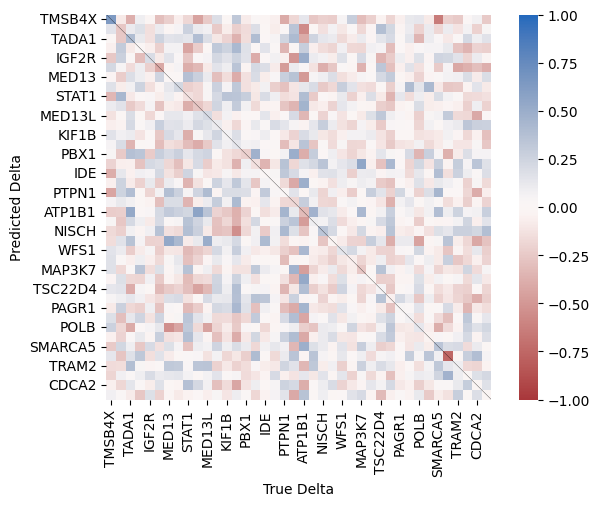

In [26]:
# Load
imputed_means = pd.read_csv('../plots/vcc/imputed_means.csv', index_col=0)
raw_means = pd.read_csv('../plots/vcc/raw_means.csv', index_col=0)

# Lose information from PCA
# raw_means[:], = preprocessing.inverse_transform(preprocessing.transform([raw_means.to_numpy()]))  # Invalid if log
# raw_means[:], = preprocessing_nopca.transform(preprocessing.inverse_transform(preprocessing.transform(preprocessing_nopca.inverse_transform([raw_means.to_numpy()]))))

# Get differences
imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_post']
# imputed_mean_diffs = imputed_means.iloc[2:] - raw_means.loc['_ctl_post']
raw_mean_diffs = raw_means.iloc[2:] - raw_means.loc['_ctl_post']

# Get 1k highly variant genes
assert preprocessing.filter_mask[0] is None
high_var_idx = preprocessing.standardize_std[0][0].argsort()[::-1][:1000]
high_var_genes = adata.var.index[high_var_idx]

# Compute correlations
# cross_correlation = np.corrcoef(imputed_mean_diffs, raw_mean_diffs)[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
cross_correlation = np.corrcoef(imputed_mean_diffs[high_var_genes], raw_mean_diffs[high_var_genes])[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
cross_correlation = pd.DataFrame(cross_correlation, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)
cross_correlation_scaled_col = (cross_correlation - np.min(cross_correlation, axis=0)) / (np.max(cross_correlation, axis=0) - np.min(cross_correlation, axis=0))
cross_correlation_scaled_row = (cross_correlation - np.min(cross_correlation, axis=1)) / (np.max(cross_correlation, axis=1) - np.min(cross_correlation, axis=1))
cross_correlation_rank = cross_correlation.shape[0] - np.argsort(np.argsort(cross_correlation, axis=0), axis=0)
cross_correlation_rank = pd.DataFrame(cross_correlation_rank, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Diagonal summary
pert_summary = pd.DataFrame({
    'Gene': cross_correlation.index,
    'Rank': np.diag(cross_correlation_rank),
    'Correlation': np.diag(cross_correlation),
    'Raw Knockdown': np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Raw Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(raw_mean_diffs[raw_mean_diffs.index], axis=0), axis=0)),
    'Imputed Knockdown': np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(imputed_mean_diffs[imputed_mean_diffs.index], axis=0), axis=0))})
pert_summary['Ratio'] = pert_summary['Imputed Knockdown'] / pert_summary['Raw Knockdown']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(cross_correlation, cmap='vlag_r', vmin=-1, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_col, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_row, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_rank, cmap='Blues_r', vmin=1, vmax=cross_correlation.shape[0], ax=ax)
ax.plot([0, cross_correlation.shape[0]], [0, cross_correlation.shape[0]], lw=.2, color='black')
ax.set(xlabel='True Delta', ylabel='Predicted Delta')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_aspect('equal')

In [27]:
pert_summary

,Gene,Rank,Correlation,Raw Knockdown,Raw Knockdown Rank,Imputed Knockdown,Imputed Knockdown Rank,Ratio
0,TMSB4X,1,0.638036,-128.150464,1,-0.376289,1,0.002936
1,PRCP,37,-0.261494,-5.708585,1,-0.001591,2,0.000279
2,TADA1,2,0.397237,-1.102620,1,-0.000216,10,0.000196
3,HIRA,25,0.000228,-0.934669,3,-0.003848,1,0.004117
4,IGF2R,3,0.202593,-3.157883,1,-0.001747,2,0.000553
5,NCK2,40,-0.420958,-1.976820,1,-0.000938,5,0.000475
6,MED13,22,0.005438,-5.648118,1,-0.002105,1,0.000373
7,MED12,6,0.230254,-3.974955,1,-0.001412,1,0.000355
8,STAT1,24,-0.139279,-2.991739,1,-0.001056,2,0.000353
9,USP22,36,-0.273032,-19.648895,1,-0.025027,2,0.001274


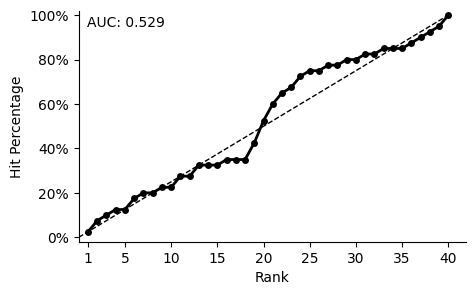

In [28]:
# Get hit df
df = pd.DataFrame({'Rank': 1+np.arange(pert_summary.shape[0])})
df['Hits'] = df['Rank'].apply(lambda r: (pert_summary['Rank'] <= r).sum())
df['Hit Percentage'] = df['Hits'] / pert_summary.shape[0]
auc = df['Hit Percentage'].mean()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(df, x='Rank', y='Hit Percentage', lw=2, marker='.', markersize=10, markeredgecolor='none', color='black', ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(-.02, 1.02)
ax.set_xticks([1]+np.arange(5, pert_summary.shape[0]+5, 5).tolist())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.))
ax.text(.02, .98, f'AUC: {auc:.3f}', ha='left', va='top', fontsize='medium', transform=ax.transAxes)
ax.plot([0, pert_summary.shape[0]], [0, 1], ls='--', lw=1, color='black')

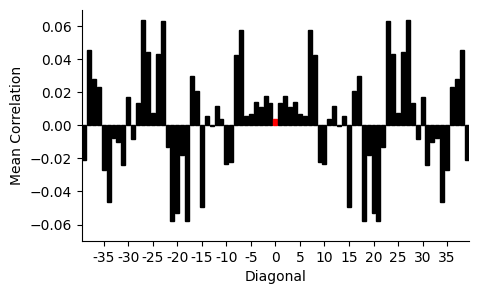

In [29]:
# Get hit df
df = pd.DataFrame({'Diagonal': np.arange(-pert_summary.shape[0]+1, pert_summary.shape[0])})
diag_corr = [np.diag(np.roll(cross_correlation, i, axis=0)).mean() for i in range(cross_correlation.shape[0])]
df['Mean Correlation'] = diag_corr[:0:-1] + diag_corr

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bar = sns.barplot(df, x='Diagonal', y='Mean Correlation', color='black', edgecolor='black', ax=ax)
# Highlight
ax.patches[len(diag_corr)-1].set(color='red', edgecolor='red')
# Styling
sns.despine(ax=ax)
max_ylim = max(*ax.get_ylim())
ax.set_ylim(-max_ylim, max_ylim)
xticks = np.arange(0, len(diag_corr), 5)
xticks = np.concat([-xticks[:0:-1], xticks])
ax.set(xticks=xticks+df['Diagonal'].max(), xticklabels=xticks);

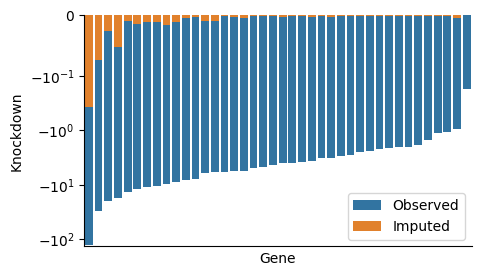

In [30]:
# Pivot
df = pert_summary.melt(id_vars='Gene', value_vars=['Raw Knockdown', 'Imputed Knockdown'], var_name='Type', value_name='Knockdown').sort_values('Knockdown')
df['Type'] = df['Type'].replace({'Raw Knockdown': 'Observed', 'Imputed Knockdown': 'Imputed'})

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bar = sns.barplot(df, x='Gene', y='Knockdown', hue='Type', dodge=False, ax=ax)
bar.get_legend().set_title('')
ax.set_yscale('symlog', linthresh=.1)
ax.set_xticks([])
# Styling
sns.despine(ax=ax)